Epoch 1/50


/opt/anaconda3/envs/gg2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 46s 436ms/step - accuracy: 0.2849 - loss: 2.0955 - val_accuracy: 0.7202 - val_loss: 1.0406
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 412ms/step - accuracy: 0.4130 - loss: 1.7286 - val_accuracy: 0.7976 - val_loss: 0.8915
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 410ms/step - accuracy: 0.4618 - loss: 1.5922 - val_accuracy: 0.8006 - val_loss: 0.7884
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 423ms/step - accuracy: 0.4761 - loss: 1.4861 - val_accuracy: 0.7917 - val_loss: 0.7542
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.5046 - loss: 1.3873 - val_accuracy: 0.7917 - val_loss: 0.7137
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 420ms/step - accuracy: 0.4732 - loss: 1.4441 - val_accuracy: 0.7679 - val_loss: 0.7343
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 417ms/step - accuracy: 0.5481 - loss: 1.2865 - val_accuracy: 0.7857 - val_loss: 0.7169
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.5187 - loss: 1.3329 - val_accuracy: 0.776

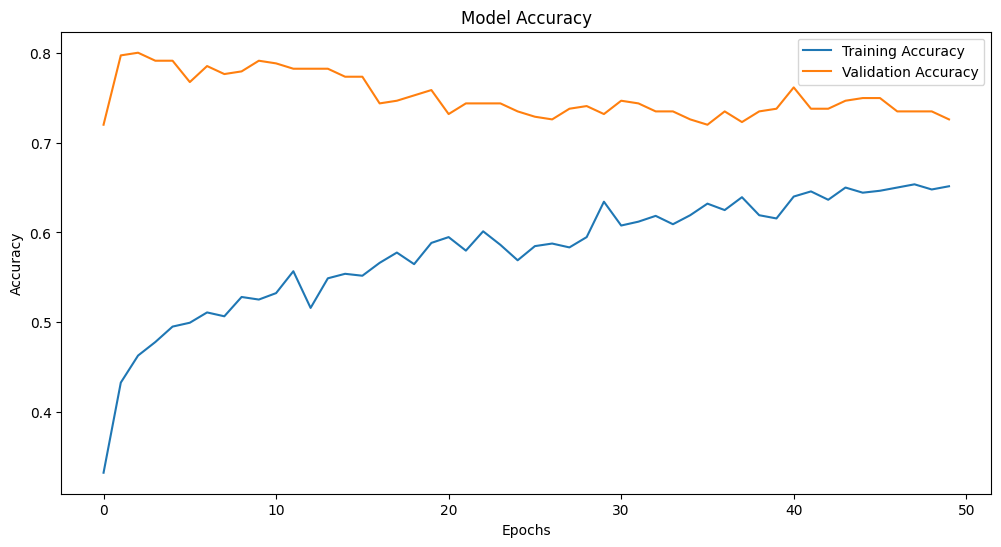

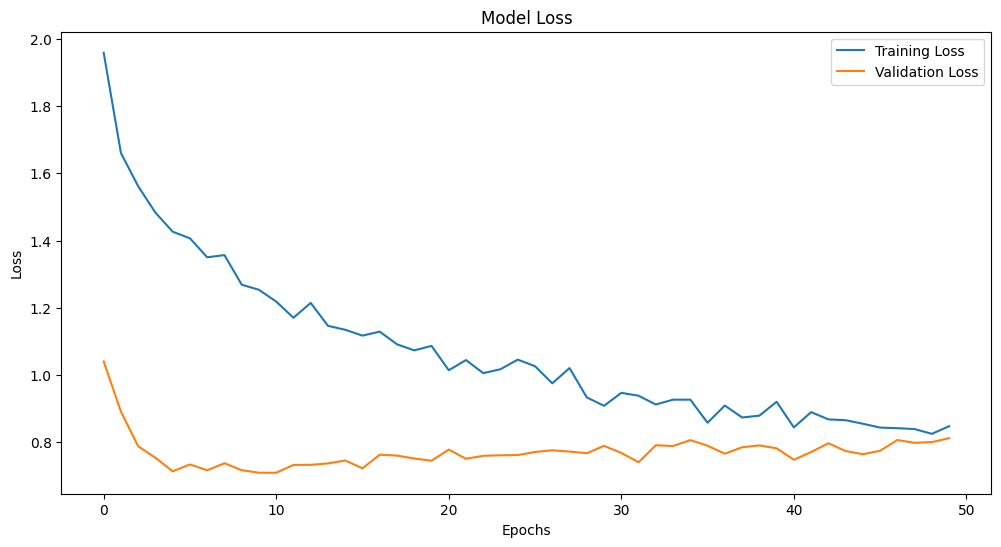

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121

# Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
CSV_PATH = '/Users/pillala/Documents/capstone project/messidor-2/messidor_data.csv'
SEGMENTED_FOLDER = '/Users/pillala/Documents/capstone project/messidor-2/segmented_images'

# 1. Load CSV data and filter gradable images
data = pd.read_csv(CSV_PATH)
data = data[data['adjudicated_gradable'] == 1]

# Image paths and labels
image_paths = data['id_code'].apply(lambda x: os.path.join(SEGMENTED_FOLDER, x)).values
labels = data['diagnosis'].values
num_classes = len(np.unique(labels))
labels = to_categorical(labels, num_classes=num_classes)

# 2. Define a Data Generator
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [self.load_image(path) for path in batch_paths]
        images = np.array(images)
        labels = np.array(batch_labels)
        return images, labels
    
    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)
    
    def load_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, self.img_size)
        return img / 255.0

# Split into training and validation sets
split_idx = int(0.8 * len(image_paths))
train_paths, val_paths = image_paths[:split_idx], image_paths[split_idx:]
train_labels, val_labels = labels[:split_idx], labels[split_idx:]

train_generator = DataGenerator(train_paths, train_labels, BATCH_SIZE, IMG_SIZE)
val_generator = DataGenerator(val_paths, val_labels, BATCH_SIZE, IMG_SIZE)

# 3. Define the EDenseNet Model
def build_edensenet(input_shape, num_classes):
    base_model = DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet', name='edensenet')
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Initialize and compile the model
model = build_edensenet((224, 224, 3), num_classes)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Callbacks
callbacks = [
    # EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# 5. Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)


# 8. Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 9. Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()